Distributed Prototype: Part 2
================

Motivation
------------

Sometimes we want to distribute computation across a cluster of computers.  Parallel programming on clusters can be both very powerful and very challenging.  It's challenging for the two following reasons:

1.  **Setup:** Setting up Hadoop/Spark/SGE often requires interacting with an IT department or screwing around a lot with EC2.
2.  **Programming:** Rewriting your program with whatever framework you've chosen can be tough.

A certain amount of this pain is unavoidable; distributed computing is intrinsically difficult.

Introduction
--------------

Over the past few weeks I been experimented with building small distributed systems to handle the small-to-medium sized cluster case.  I've iterated on this design several times; it's been a lot of fun.  

[Two weeks ago](http://matthewrocklin.com/blog/work/2015/10/09/Distributed/) I wrote about a [small distributed computing project](https://distributed.readthedocs.org/en/latest/).  Based on feedback this project has changed significantly, so I'm going to write about it again.

The `distributed` project now provides a user interface that mimics Python's [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) standard library, in particular it focuses on the `Executor` and `Future` abstractions.  It deviates a bit from `concurrent.futures` a bit in order to better support distributed computing workloads.  I'm going to avoid repeating [the docs](https://distributed.readthedocs.org/en/latest/) so this post will just be a couple of toy examples, along with motivation for why those examples work well.

I should also note that [`SCOOP`](http://scoop.readthedocs.org/en/latest/) is another fine project that implements Executors on distributed machines.

### Outline

*  Set up a local cluster
*  Connect to cluster and run trivial example
*  Discuss less trivial example with numpy arrays
*  Run a custom algorithm with `Executor.submit`
*  Discuss low scheduling overhead
*  Connect executor to `dask.array`

Set up a Local Cluster
--------------------------

To set up workers and center locally first install `distributed`:

```
$ pip install distributed --upgrade
```

Then open up four terminals and run the following:

```
$ dcenter                 # terminal 0
$ dworker 127.0.0.1:8787  # terminal 1
$ dworker 127.0.0.1:8787  # terminal 3
$ dworker 127.0.0.1:8787  # terminal 4
```

Alternatively, if you can ssh into your own machine, then just run the following:

```
$ dcluster 127.0.0.1 127.0.0.1 127.0.0.1 127.0.0.1
```

This will also work for other hostnames to which you have `ssh` access.

Here are instructions to set up a remote cluster and run this notebook using `anaconda-cluster`:

*  https://gist.github.com/mrocklin/3c1e47f403490edb9473

## Connect to Cluster

After setting up center and worker nodes we can connect to the center node from a local Python process.

The `executor` serves as our contact point to the cluster.

In [1]:
from distributed import Executor
executor = Executor('127.0.0.1:8787')

`submit` simple job
----------------------

We submit a simple function application to the cluster.  The data and function will execute asynchronously on one of the workers.  We get a `Future` back.

In [2]:
from operator import add
def inc(x):
    return x + 1

a = executor.submit(inc, 1)
a

<Future: status: waiting, key: inc-8bca9db48807c7d8bf613135d01b875f>

In [3]:
a.result()

2

The following just happened:

1.  The `executor` sends `inc` and `1` to a remote worker
2.  That remote worker computes `inc(1)` and stores the result on itself
3.  We call `a.result()` and the worker sends us the result, `2`

Moving data back and forth can be wasteful, particularly when data becomes large and when we want to iterate several computations on the same data.

`submit` works on `Futures`
-------------------------------

Often we want to call further functions on our future results.  

Under the normal `concurrent.futures` API we would collect future results explicitly before submiting the next call.

```python
a = executor.submit(inc, 1)
b = executor.submit(inc, 10)
c = executor.submit(add, a.result(), b.result())
```

This can be wasteful in a distributed memory context because data transfer can be expensive.  We want to avoid moving the results of `a` and `b` to the local process just to send them back out again.

And so, our main API break from `concurrent.futures`.  The `submit` function works directly on futures.

In [4]:
a = executor.submit(inc, 1)
b = executor.submit(inc, 10)
c = executor.submit(add, a, b)  # no calls to .result() here
c

<Future: status: waiting, key: add-f3347ff447ec6b697ffb95c324028bdc>

In [5]:
c.result()

13

This is useful for two reasons

1.  **Avoid moving data to the local process**:  We keep data on the distributed network.  This avoids unnecessary data transfer.
2.  **Fire and forget**: We don't have to reason about which jobs finish before which others.  The scheduler takes care of this for us.

However this is also complex; the `Executor` needs to track what has and has not run.  Fortunately this is very similar to how dask schedulers function, so we can steal some logic from that project.

Dependency graphs
--------------------

In order to track the progress of all Futures, the Executor manages a dependency graph.  Internally this is just a [dask graph](dask.readthedocs.org/en/latest/).

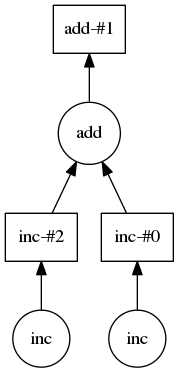

In [6]:
# !sudo apt-get install graphviz
# !pip install graphviz

from dask.dot import dot_graph
dot_graph(executor.dask)

Example: Arrays
------------------

We perform a slightly less trivial example

1.  Make 16 random arrays
2.  Sum each array
3.  Compute the total of the sums

The scheduler is smart enough to load balance the creation of the arrays and to compute the sum of each array on the same machine where it already exists.  This entire computation requires very little data transfer over the network.  It should feel pretty snappy.

In [7]:
import numpy as np
arrays = executor.map(np.random.random, [1000000] * 16, pure=False)

In [8]:
sums = executor.map(np.sum, arrays)

In [9]:
total = executor.submit(sum, sums)

In [10]:
total.result()

8002464.1928601526

These computations add onto our previous graph.  You can see the array creation and sums alongside our old `inc/inc/add` graph off to the side from last section.

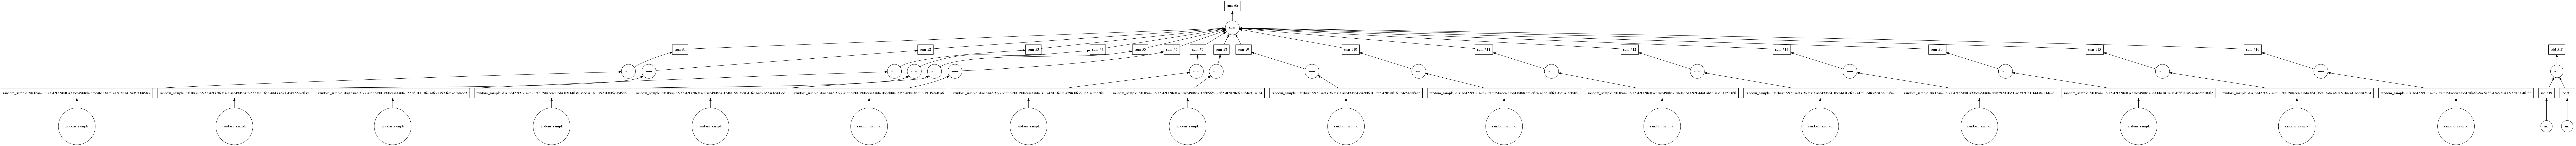

In [11]:
dot_graph(executor.dask)

More complex algorithms
--------------------------

Direct access to an efficient, distributed, data-local `submit` function gives us a lot of freedom when writing algorithms.

As consider adding together our arrays in a pairwise binary reduction tree.  It might look like the following:


```
         total
       /        \
     z1          z2
    /  \        /  \
  y1    y2    y3    y4
 / \   / \   / \   / \
x1 x2 x3 x4 x5 x6 x7 x8 
```

In a typical parallel programming framework this kind of algorithm needs to be baked in.  If we're lucky then users are given a special `reduction_tree` function.  However in our case we use `submit` to code up this behavior directly.  This low-level approach won't be as scalable, but it's trivial API and easy to use in complex settings.

We do this directly with many calls to `executor.submit` in a while loop.  


In [12]:
xs = arrays
while len(xs) > 1:
    xs = [executor.submit(add, xs[i], xs[i + 1]) 
          for i in range(0, len(xs), 2)]

In [13]:
xs[0].result()

array([  2.069694  ,   9.01727599,   5.42682524, ...,   0.42372487,
         1.50364966,  13.48674896])

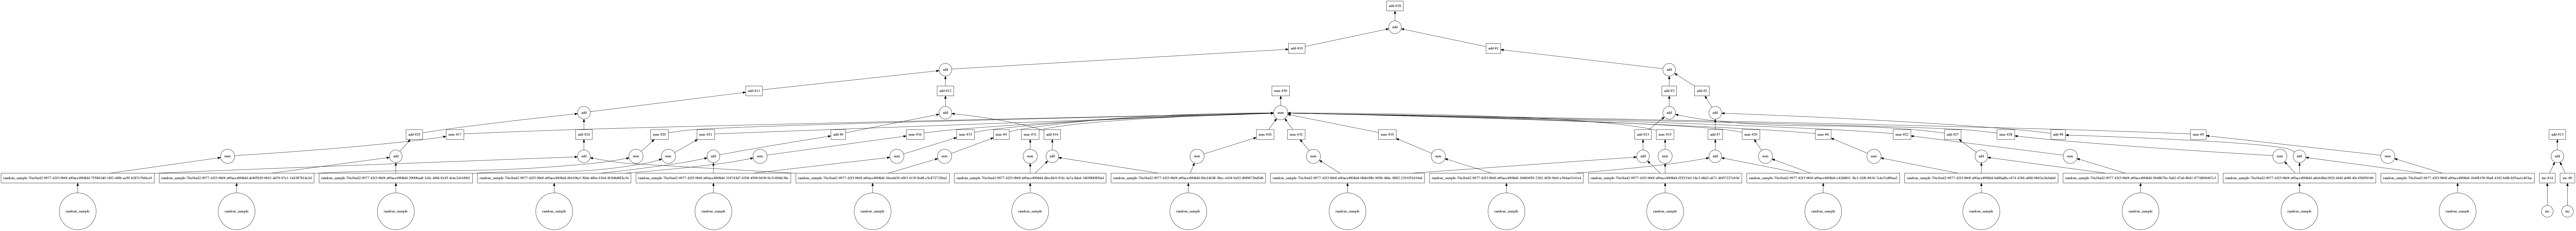

In [14]:
dot_graph(executor.dask)

Note that our graph has grown again.  Also note that it grew off of the previous data.  We didn't make new nodes for the arrays, we reused existing intermediate results.  When we compute on the same Futures in our local process the workers compute on the same data on the cluster.

Overhead
---------

Lets do all of that over again, but now capture total runtime cost.  We'll do that both with `distributed.Executor` and with `concurrent.futures.ThreadPoolExecutor`.

### `distributed.Executor`

In [15]:
%%time

xs = executor.map(np.random.random, [1000000] * 16, pure=False)
while len(xs) > 1:
    xs = [executor.submit(add, xs[i], xs[i + 1]) 
          for i in range(0, len(xs), 2)]
    
xs[0].result()

CPU times: user 71.6 ms, sys: 9.32 ms, total: 80.9 ms
Wall time: 325 ms


### `concurrent.futures.ThreadPoolExecutor`

In [16]:
from concurrent.futures import ThreadPoolExecutor
tp_executor = ThreadPoolExecutor(8)

In [17]:
%%time 

xs = [tp_executor.submit(np.random.random, 1000000) for i in range(16)]
while len(xs) > 1:
    xs = [tp_executor.submit(add, xs[i].result(), xs[i + 1].result()) 
          for i in range(0, len(xs), 2)]
    
xs[0].result()

CPU times: user 238 ms, sys: 16.7 ms, total: 254 ms
Wall time: 208 ms


Unsurprisingly, `ThreadPoolExecutor` is faster.  The problem is small enough that we're mostly bound by overhead.  Interestingly though, the overhead of the distributed system *isn't that large*.  We're still within the realm of user-interactive speeds.

`dask get`
------------

Finally, the Executor also satisfies the `dask.get` interface and so can power parallel dask collections, like [`dask.array`](http://dask.pydata.org/en/latest/array.html) .  We can give an executor an entire graph and it will roll that computation in with the others.  The executor can be much smarter when we give it entire graphs.  This will also cut down significantly on the scheduling overhead.

We'll do the following

1.  Use `dask.array` to create a graph to do the computation we did above
2.  Execute that graph locally with `dask.threaded.get`
3.  Execute that graph on distributed with `executor.get`
4.  Compare runtimes

### Make dask array computation

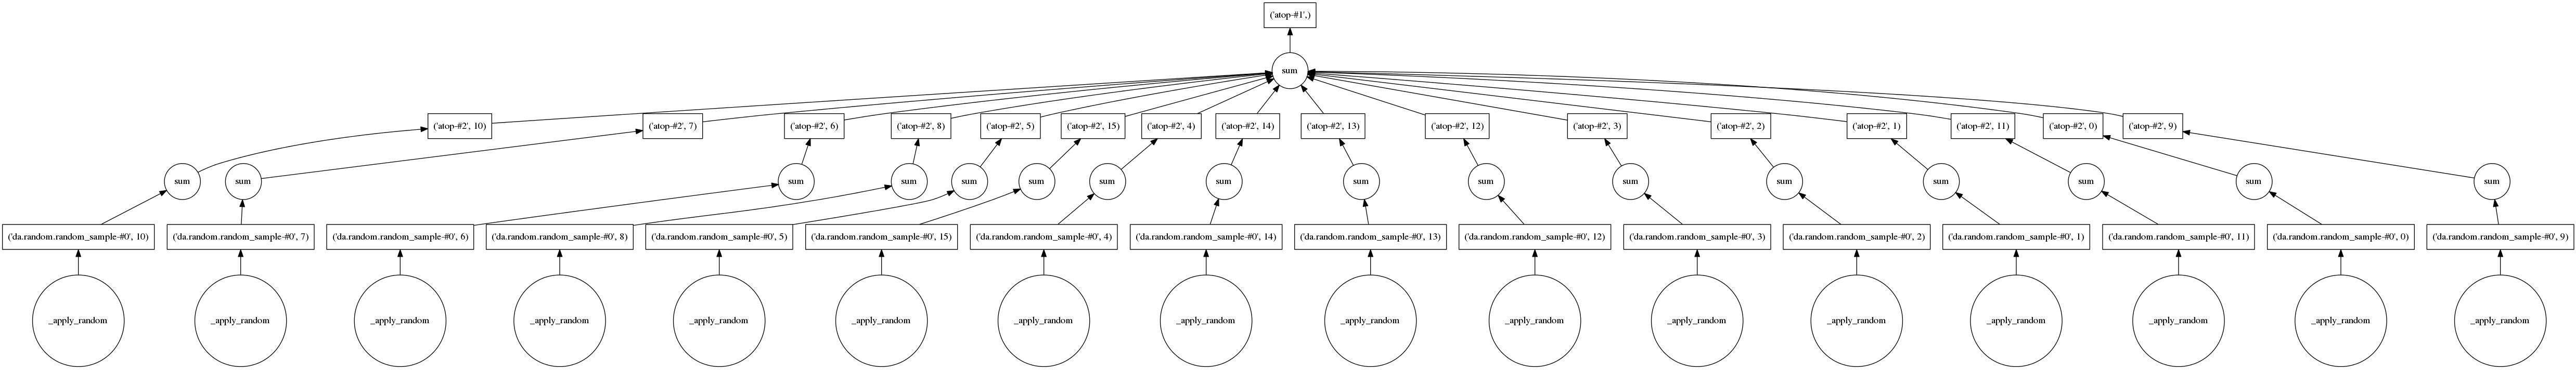

In [18]:
import dask.array as da
x = da.random.random(size=16000000, chunks=(1000000,))
total = x.sum()
total.visualize()

### Execute in local process with threads

In [19]:
%time total.compute()

CPU times: user 313 ms, sys: 14.3 ms, total: 327 ms
Wall time: 65.9 ms


8002036.723719107

### Execute with distributed cluster

For a problem of this size we expect the local solution to be faster.  This is fast enough that distributed scheduling overhead is likely to dominate.

In [20]:
%time total.compute(get=executor.get)

CPU times: user 32.5 ms, sys: 4.07 ms, total: 36.6 ms
Wall time: 101 ms


8002036.723719107

And again, the distributed solution is slower but not incredibly slow.

Of course, this was done on a local machine without worrying about network latency.  If we add in typical network delays we should expect our overhead to increase.  

What's next?
--------------

First, please give feedback.  The executor exists largely because [people asked for it](https://github.com/mrocklin/distributed/pull/3#issuecomment-146910408).  So please, ask for things.

Recent work includes the following:

*  Using the scheduler, identifying bugs, and fixing things.  Help exercising `distributed` is most welcome.
*  Garbage collection of remote data
*  Resilience to dropped data
*  Scripts to ease deployment
*  [Writing Documentation](distributed.readthedocs.org)

If you have thoughts or idea on where this project should go please

*  [Raise an issue](https://github.com/mrocklin/distributed/issues/new)
*  Come to the [distributed gitter chat](https://gitter.im/mrocklin/distributed)

I'm also quite open to ideas for a better name.